In [150]:
import subprocess
from multiprocessing import Pool
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
#import statsmodels.api as smdl
%run averaging.ipynb
%run optimize_slope.ipynb

In [151]:
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

In [152]:
def write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True):
    ftext = """sprintf(my_seed,"%05g",SEED)

    iterations = e3

    INCLUDE_FILE = "../outputLoc.mdl"
    INCLUDE_FILE = "../initialization.mdl"
    INCLUDE_FILE = "parameters.mdl"
    /* Modifications in Parameters */
        VDCC_number_presynaptic = 40

        n_Glu_neuron =  1 //2000
        GluT_density_astrocyte = 0.1 //1000

        ca_conc_presynaptic_er = e-6     //initial ER conc specified here!!!!!
        //ryr_number_presynaptic = 0 //no RYR

    f =                                 //SERCA parameter adjustments here!!!!!!!!!!

    sm = //multiply all serca parameters

    /*Initial SERCA fractions*/
    serca_x1_feq = 
    serca_x1a_feq = 
    serca_x2_feq = 
    serca_y1_feq = 
    serca_y1a_feq = 
    serca_y2_feq = 

    INCLUDE_FILE = "rxn_rate_constants.mdl"
    /* Modifications in Reaction Rate Constants */
    //k_PMCA_0_1 = 0
    //k_PMCA_0_leak = 0


    /* Output Folder */
            //isi = "40"
        sprintf(VDCC, "%g", VDCC_number_presynaptic)
        sprintf(f_mult, "%g", f) 
        sprintf(s_mult, "%g", sm) 
        sprintf(init_er_conc, "%g", ca_conc_presynaptic_er*1e6)   	
        fname = 

        output_folder = outputLoc & "ppf/" & fname & "/sm" & s_mult & "/" & f_mult & "/" & init_er_conc & "/s_" & my_seed

    /* Rates for P/Q-type Voltage Dependent Calcium Channels */
    /* From Bischoffberger et al., 2005, , Biophys. J.*/

        k_VDCC_PQ_C01 = 0
        k_VDCC_PQ_C12 = 0
        k_VDCC_PQ_C23 = 0
        k_VDCC_PQ_C34 = 0
        k_VDCC_PQ_C43 = 0
        k_VDCC_PQ_C32 = 0
        k_VDCC_PQ_C21= 0
        k_VDCC_PQ_C10 = 0
        k_VDCC_PQ_Ca = 0

    INCLUDE_FILE = "triggered_release.inc.mdl"

    INCLUDE_FILE = "rxn_outputRS.mdl"
    //INCLUDE_FILE = "viz_output.mdl"
    """
    ftext=ftext.replace('iterations = ', 'iterations = '+str(iterations))
    ftext=ftext.replace('sm = ', 'sm = '+str(sm))
    ftext=ftext.replace('ca_conc_presynaptic_er = ', 'ca_conc_presynaptic_er = '+str(ic))
    ftext=ftext.replace('f = ','f = '+str(sf))
    ftext=ftext.replace('fname = ','fname = '+'"'+str(outfolder)+'"')
    for i,p in enumerate(['x1','x1a','x2','y2','y1a','y1']):
        old="serca_"+p+"_feq = "
        new="serca_"+p+"_feq = "+str(serca_frac[i])
        ftext=ftext.replace(old,new)
    if write:
        with open(file_name,'w') as wfile:
            wfile.write(ftext)

            

In [140]:
%run get_SERCA_equilibrium.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[100,300,400,450,477,490,495]
serca_mult=[3,6,9,12,15]

folder="/home/kabir/Project/tripartiteSynapse/brute750_8/"
outfolder="brute9"


iterations=5000
fnames=[]

for sm in serca_mult:
    for ic in initial_conc:
        serca_frac=get_SERCA_equilibrium(ic)
        file_name=folder+"RSnostim_sm"+str(sm)+"_ic"+str(ic)+"_fc"+str(final_conc)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)
        

In [145]:
%run get_SERCA_equilibrium.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[0]
serca_mult=[70,100,150]

folder="/home/kabir/Project/tripartiteSynapse/brute750_8/"
outfolder="brute9"


iterations=20000
fnames=[]

for sm in serca_mult:
    for ic in initial_conc:
        serca_frac=[1,0,0,0,0,0]
        file_name=folder+"RSnostim_sm"+str(sm)+"_ic"+str(ic)+"_fc"+str(final_conc)+"long.mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)

In [25]:
%run get_SERCA_equilibrium.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[100,300,450,475,490,500]
serca_mult=[100,300,500,700]

folder="/home/kabir/Project/tripartiteSynapse/brute750_8/"
outfolder="brute9"


iterations=5000
fnames=[]

for sm in serca_mult:
    for ic in initial_conc:
        serca_frac=get_SERCA_equilibrium(ic)
        file_name=folder+"RSnostim_sm"+str(sm)+"_ic"+str(ic)+"_fc"+str(final_conc)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)
        

In [146]:
#write run.sh
with open(folder+'run.sh','w') as f:
    for name in fnames:
            f.write("qsub -N "+name.replace('.mdl','').replace(folder,'')+" -v I='"+name.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")

In [147]:
#sync script files to cluster
p=subprocess.call(["rsync","-arhP",folder[:-1],"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/"])

In [165]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/brute9","/data/kabir/output/ppf/"])

In [4]:
#average 500 for f
ic=500

initial_conc=[100,300,400,450,477,490,495]
serca_mult=[3,6,9,12,15]
sf=2

for sm in serca_mult:
    for ic in initial_conc:
        averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        
#load data 500
data={}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

In [125]:
#average 750 for f
ic=750

serca_mult=[3,6,9,12,15]
serca_f=[3]

#serca_mult=[1]#[3,6,9,12,15]#[1]
#serca_f=[2,2.2,2.4,2.6,2.8,2.9,3,3.1,3.2,3.4,3.6,3.8,4]

for sm in serca_mult:
    for sf in serca_f:
        averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        
#load data 750
data={}
ic=750
for sm in serca_mult:
    data[sm]={}
    for sf in serca_f:
        data_file='/data/kabir/output/ppf/brute8/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][sf]=np.loadtxt(data_file)
        data[sm][sf].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar """

In [158]:
%run averaging.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[100,300,450,475,490,500]
serca_mult=[100,300,500,700]
data_locs=[]
for sm in serca_mult:
    for ic in initial_conc:
        #averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        data_locs.append("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
p=Pool(7)
data_list=p.map(averager,data_locs)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [63]:
"""data={}
for i,sm in enumerate(serca_mult):
    data[sm]={}
    for j,ic in enumerate(initial_conc):
        #print('i=',i,'j=',j)
        #print(i*sm_len+j)
        data[sm][ic]=data_list[i*sm_len+j]
        #data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6"""
#load data 500
data={}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

Text(0,0.5,'ER Ca2+ conc (uM)')

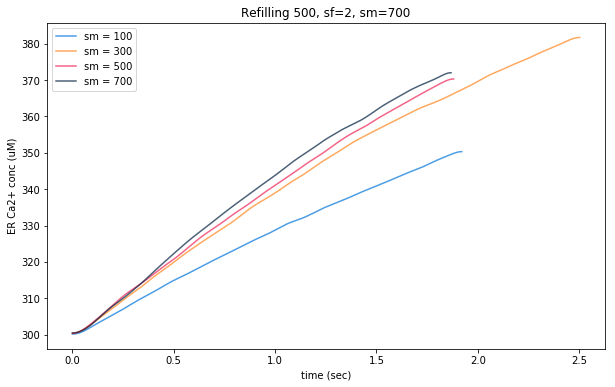

In [128]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
#sm=500
ic=300
plt.figure(figsize=(10,6))
for i,sm in enumerate(serca_mult):
    ydata=data[sm][ic].T[1]
    xdata=data[sm][ic].T[0]
    ydata = gaussian_filter1d(ydata, sigma=300)
    slope,intercept,tau=eval_tau_at_time(0.5,xfor sm in serca_mult:
    for sf in serca_f:
        averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        
#load data 750
data={}
ic=750
for sm in serca_mult:
    data[sm]={}
    for sf in serca_f:
        data_file='/data/kabir/output/ppf/brute8/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][sf]=np.loadtxt(data_file)
        data[sm][sf].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar """data,ydata,500)
    
    plt.plot(xdata,ydata,color=color[i%12],label='sm = '+str(sm), alpha=0.7)
    #xline=np.linspace(0,2,100)
    #yline=slope*xline+intercept
    #plt.plot(xline,yline,color=color[i%12])
    #print("(Optimum sf, error)=",optimize_slope(data[sm],250))
plt.legend()
plt.title("Refilling 500, sf="+str(sf)+", sm="+str(sm))
plt.xlabel('time (sec)')
plt.ylabel('ER Ca2+ conc (uM)')
#plt.ylim((120,180))
#plt.xlim((0.25,0.75))
#plt.savefig('/home/kabir/Project/plots/brute6/new_sf_750.eps')#"""
#plt.savefig('/home/kabir/Project/midsemreport_spring2019/new_sm.eps')
#print(optimize_slope(data[sm],750))

In [137]:
def eval_tau_at_time(t,xdata,ydata,A):
    tstep=xdata[1]-xdata[0]
    delta_t=0.1
    lower,upper=int((t-delta_t)/tstep),int((t+delta_t)/tstep)
    a, b, r_value, p_value, std_err= stats.linregress(xdata[lower:upper],ydata[lower:upper])
    conc=a*t+b
    tau= (A-conc)/a
    #print('conc=',conc,'tau=',tau,'error=',std_err)
    return a,b,tau

sm= 100
sm= 300
sm= 500
sm= 700


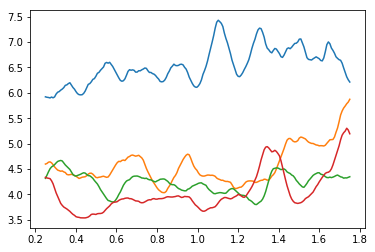

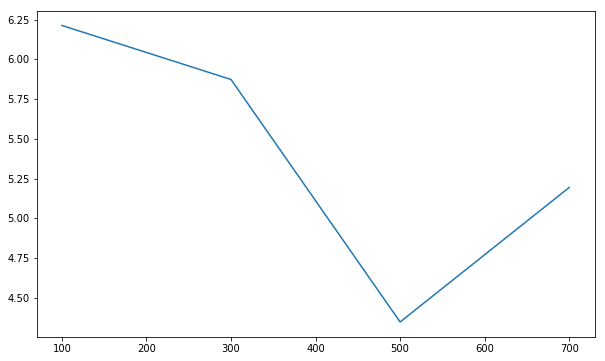

In [138]:
serca_mult=[100,300,500,700]

ic = 300
taus=[]
for sm in serca_mult:
    ydata=data[sm][ic].T[1]
    xdata=data[sm][ic].T[0]
    print('sm=',sm)
    tau_i=[]
#    eval_tau_at_time(1,xdata,ydata,500)
    for t in np.linspace(0.25,1.75,200): 
        slope,intercept,tau=eval_tau_at_time(t,xdata,ydata,500)
        tau_i.append(tau)
    plt.plot(np.linspace(0.25,1.75,200),tau_i)
    taus.append(np.average(tau))
    
plt.figure(figsize=(10,6))
plt.plot(serca_mult,taus)

In [166]:
#average,full refilling
initial_conc=[0]

serca_mult=[70,100,150]
serca_f=[2]

#serca_mult=[1]#[3,6,9,12,15]#[1]
#serca_f=[2,2.2,2.4,2.6,2.8,2.9,3,3.1,3.2,3.4,3.6,3.8,4]

data_locs=[]
for sm in serca_mult:
    for ic in initial_conc:
        #averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        data_locs.append("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
p=Pool(7)
data_list=p.map(averager,data_locs)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [167]:
#load data, full refilling
data={}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

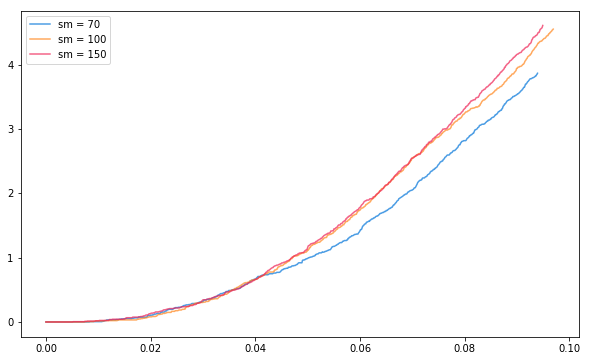

In [168]:
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

ic=0
plt.figure(figsize=(10,6))
for i,sm in enumerate(serca_mult):
    ydata=data[sm][ic].T[1]
    xdata=data[sm][ic].T[0]
    plt.plot(xdata,ydata,color=color[i%12],label='sm = '+str(sm), alpha=0.7)

plt.legend()
